### Named Entity Recognition 

In [1]:
import os
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

bbc_path = "Desktop/bbc"

#dataFrame to store entities
entities_df = pd.DataFrame(columns=['Entity', 'Category', 'Topic'])

# Iterate through each topic folder
for topic in os.listdir(bbc_path):
    topic_path = os.path.join(bbc_path, topic)
    if os.path.isdir(topic_path):
        # Iterate through each file in the topic folder
        for file_name in os.listdir(topic_path):
            file_path = os.path.join(topic_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                doc = nlp(content)
                for ent in doc.ents:
                    new_row = pd.DataFrame({'Entity': [ent.text], 'Category': [ent.label_], 'Topic': [topic]})
                    entities_df = pd.concat([entities_df, new_row], ignore_index=True)

In [2]:
print(entities_df.head())

        Entity Category     Topic
0  Time Warner      ORG  business
1    Quarterly     DATE  business
2           US      GPE  business
3   TimeWarner      ORG  business
4          76%  PERCENT  business


#### Count Entities by Category

In [3]:
entity_counts = entities_df['Category'].value_counts()
print(entity_counts)

Category
PERSON         20399
ORG            18989
DATE           13543
GPE            12876
CARDINAL        8144
NORP            4596
MONEY           2647
ORDINAL         2397
PERCENT         1949
LOC             1115
TIME             818
WORK_OF_ART      786
EVENT            753
PRODUCT          680
FAC              623
QUANTITY         250
LAW              150
LANGUAGE         120
Name: count, dtype: int64


#### Count Entities by Topic

In [4]:
entity_topic_counts = entities_df.groupby(['Topic', 'Category']).size().unstack(fill_value=0)
print(entity_topic_counts)

Category       CARDINAL  DATE  EVENT  FAC   GPE  LANGUAGE  LAW  LOC  MONEY  \
Topic                                                                        
business           1536  3840     36   33  3345         2   34  335   1372   
entertainment      1380  2465    100  219  1813        17   20  147    541   
politics           1124  2217     79  131  1967        25   44  235    320   
sport              2171  2994    503  194  3992        38   25  159     84   
tech               1933  2027     35   46  1759        38   27  239    330   

Category       NORP  ORDINAL   ORG  PERCENT  PERSON  PRODUCT  QUANTITY  TIME  \
Topic                                                                          
business       1051      275  4739     1259    2401      121        61    82   
entertainment   661      459  2796       79    4764      126        16   129   
politics       1375      318  3510      203    4264       83        11   109   
sport          1001      976  3474       23    6936  

#### Visualization

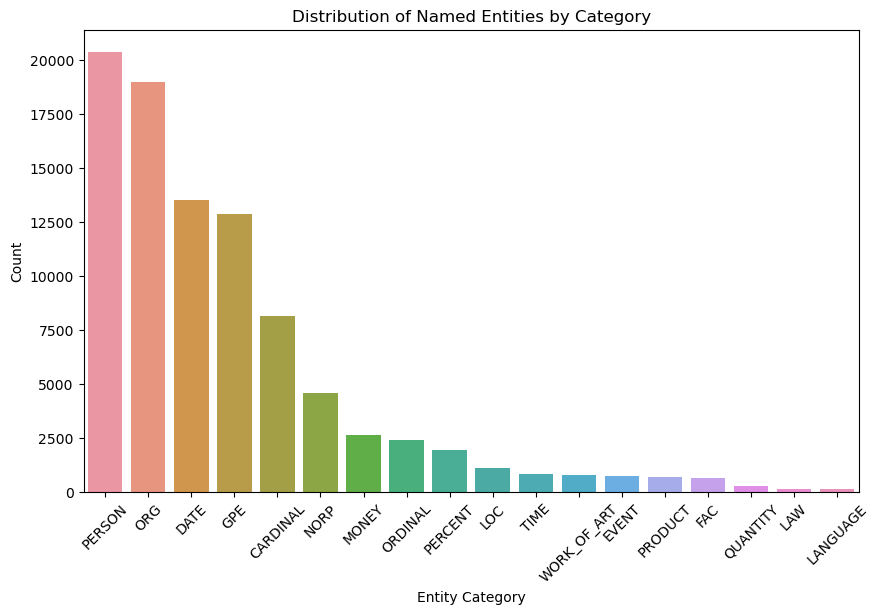

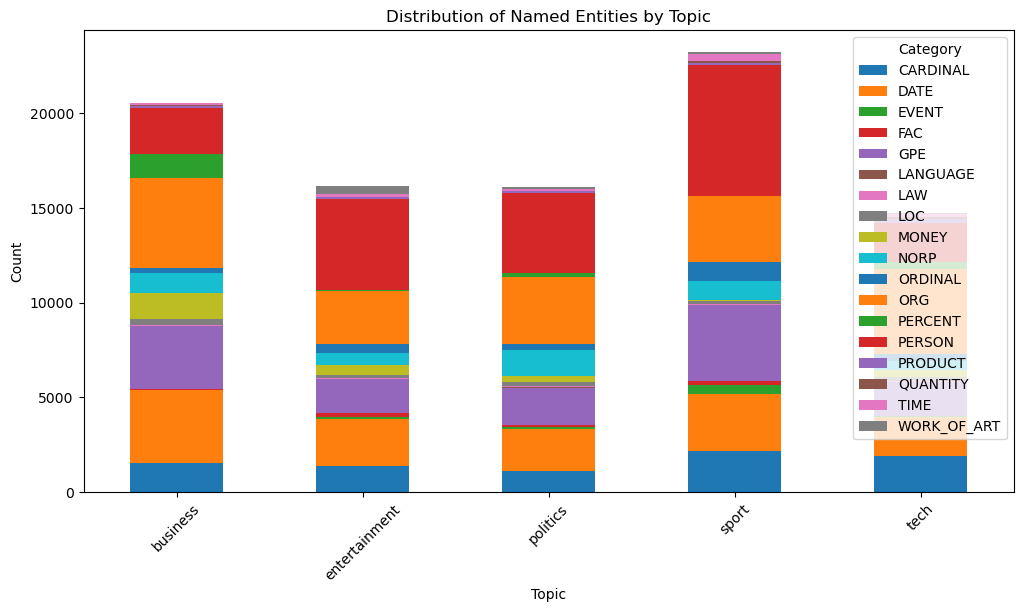

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#plotting the distribution of entities by category
plt.figure(figsize=(10, 6))
sns.barplot(x=entity_counts.index, y=entity_counts.values)
plt.title('Distribution of Named Entities by Category')
plt.xlabel('Entity Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#plotting the distribution of entities by topic
entity_topic_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Named Entities by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Sentiment Analysis 

In [6]:
from textblob import TextBlob
import os
import pandas as pd

bbc_path = "Desktop/bbc"  
all_documents = []  

# Iterate through each topic folder
for topic in os.listdir(bbc_path):
    topic_path = os.path.join(bbc_path, topic)
    if os.path.isdir(topic_path):
        # Iterate through each file in the topic folder
        for file_name in os.listdir(topic_path):
            file_path = os.path.join(topic_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                all_documents.append({'Topic': topic, 'Content': content})

documents_df = pd.concat([pd.DataFrame([doc]) for doc in all_documents], ignore_index=True)

In [7]:
documents_df['Sentiment'] = documents_df['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)

#### Overall Distribution

In [8]:
sentiment_distribution = documents_df['Sentiment'].value_counts()
print(sentiment_distribution)

Sentiment
 0.170335    3
 0.075000    3
 0.175000    3
 0.033129    2
 0.045382    2
            ..
 0.101416    1
-0.083377    1
 0.167424    1
 0.137319    1
 0.071316    1
Name: count, Length: 2065, dtype: int64


#### Sentiment by Topic

In [9]:
sentiment_by_topic = documents_df.groupby('Topic')['Sentiment'].mean()
print(sentiment_by_topic)

Topic
business         0.059611
entertainment    0.148100
politics         0.070124
sport            0.112957
tech             0.103213
Name: Sentiment, dtype: float64


#### Visualization

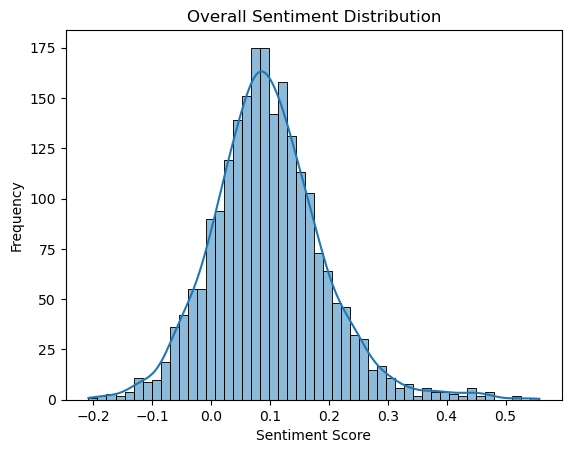

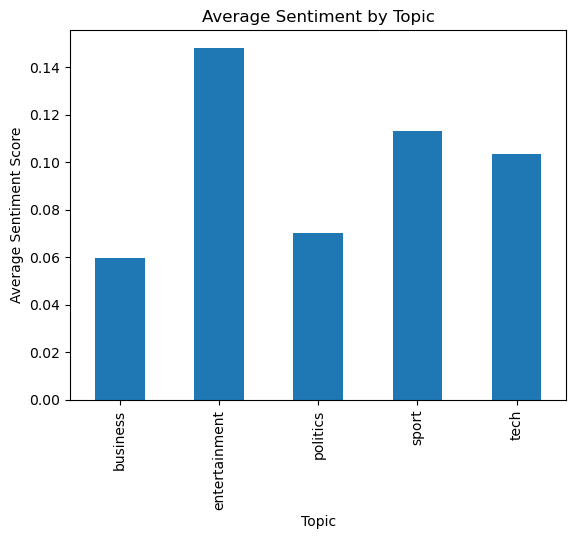

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overall Sentiment Distribution
sns.histplot(documents_df['Sentiment'], bins=50, kde=True)
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Sentiment by Topic
sentiment_by_topic.plot(kind='bar')
plt.title('Average Sentiment by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

### Topic Modeling

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

#function for basic text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Tokenization
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

documents_df['Processed_Content'] = documents_df['Content'].apply(preprocess_text)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents_df['Processed_Content'])

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
#Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#Display the top words in each topic
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
said year film best game award win time england player
Topic 1:
game said site email security virus people attack program software
Topic 2:
said people music mobile technology phone new service year digital
Topic 3:
said year bn company firm market mr bank new sale
Topic 4:
said mr government labour party people election minister say blair


In [13]:
dominant_topic = lda.transform(X).argmax(axis=1)
documents_df['Dominant_Topic'] = dominant_topic

topic_distribution = documents_df['Dominant_Topic'].value_counts()
print(topic_distribution)

Dominant_Topic
0    747
3    550
4    449
2    360
1    119
Name: count, dtype: int64


In [16]:
# Calculate average sentiment per topic
average_sentiment_per_topic = documents_df.groupby('Dominant_Topic')['Sentiment'].mean()
print(average_sentiment_per_topic)

Dominant_Topic
0    0.140838
1    0.058328
2    0.112899
3    0.058161
4    0.069354
Name: Sentiment, dtype: float64


#### Visualization

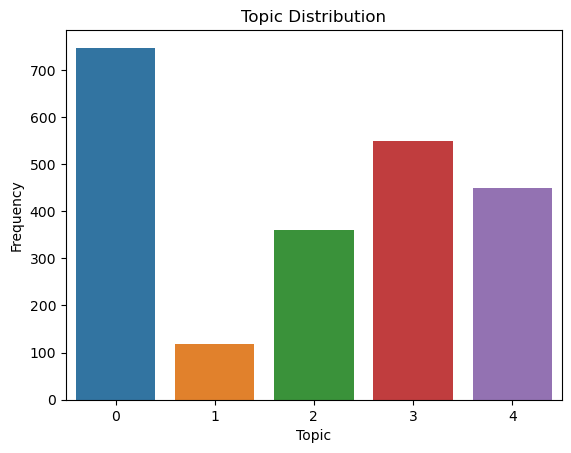

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize topic distribution
sns.barplot(x=topic_distribution.index, y=topic_distribution.values)
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()